In [24]:
!pip install koreanize-matplotlib

생성 데이터 크기
(480, 20)
(480,)

차원 확장
torch.Size([480, 20, 1])

Y 차원
torch.Size([480, 1])

입력 X shape (for LSTM): torch.Size([20, 480, 1])
타깃 Y shape: torch.Size([480, 1])
[ 0.          0.19906212  0.39015654  0.5656344   0.7184721   0.84255207
  0.9329078   0.9859227   0.9994748   0.97302175  0.9076222   0.80589396
  0.6719088   0.51102966  0.32969588  0.13516563 -0.06477479 -0.2621225
 -0.44897848 -0.6178635 ]
-0.7620177268981934


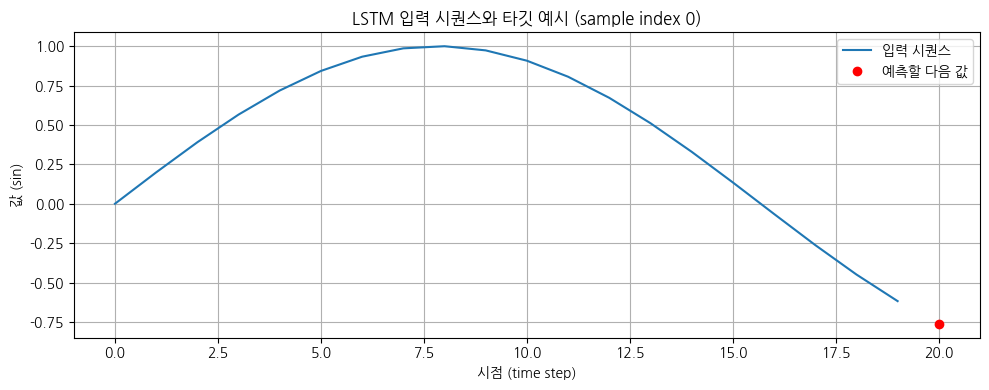

In [25]:
# 1. 필요한 라이브러리 임포트
import numpy as np
import torch
import matplotlib.pyplot as plt
import koreanize_matplotlib  #!pip install koreanize-matplotlib


# 2. sin 곡선 데이터 생성
x = np.linspace(0, 100, 500)            # 0부터 100까지 총 500개의 점을 균등 간격으로 생성합니다.
y = np.sin(x)                           # 각 점에 대해 sin 함수를 적용하여 sin 곡선 형태의 데이터 생성

# 3. 시계열 데이터를 (입력 시퀀스, 예측 값) 쌍으로 변환하는 함수 정의
def make_sequence(data, seq_len):
    """
    전체 연속 데이터를 일정 길이의 시퀀스로 자르고,
    각 시퀀스 다음 시점을 예측할 값으로 설정합니다.

    예: seq_len = 3인 경우,
    입력 시퀀스: [0]~[2], 타깃: [3]
              [1]~[3], 타깃: [4]
                ...
    """
    x_seq, y_seq = [], []
    for i in range(len(data) - seq_len):
        x_seq.append(data[i:i+seq_len])        # 입력 시퀀스: 현재 시점부터 seq_len 길이만큼 자름
        y_seq.append(data[i+seq_len])          # 타깃 값: 해당 시퀀스 바로 다음 시점의 값
    return np.array(x_seq), np.array(y_seq)     # 결과를 numpy 배열로 반환

# 4. 시퀀스 길이 설정 및 시퀀스 생성
seq_len = 20                            # 입력 시퀀스 길이를 20으로 설정
X, Y = make_sequence(y, seq_len)        # 전체 sin 데이터에서 입력 시퀀스 X와 타깃 Y 생성

print("생성 데이터 크기")
print(X.shape) #(480,20) #500개 데이터를 20길이 시퀀스로 자름.
print(Y.shape) #(480,)
print()

# 5. PyTorch Tensor로 변환 및 입력 차원 확장
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
# shape: (samples, seq_len, 1)
# 각 시퀀스는 길이 seq_len(20)이고, 각 시점은 scalar(1차원 입력) 값이므로 마지막에 차원 추가
# (480, 20, 1)
print("차원 확장")
print(X.shape)
print()

Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)
# shape: (samples, 1)
# 각 타깃은 하나의 스칼라 값이며, 모델 출력을 위한 형식으로 변환
print("Y 차원")
print(Y.shape)
print()



# 6. 차원 변경: LSTM 모듈이 요구하는 입력 형태로 변환
X = X.permute(1, 0, 2)  # shape 변경: (samples, seq_len, 1) → (seq_len, batch_size, input_size)
# LSTM은 (seq_len, batch_size, input_size) 형태의 입력을 기대함(batch_first = false 가 기본)
# 따라서 차원 순서를 변경해 LSTM에 바로 넣을 수 있도록 정리
# 20개의 시점을 가진 시퀀스들이
# 480개 배치로 묶여,
# 각 시점마다 1개의 입력값을 갖는 형태입니다.



# 7. 확인용 출력
print(f"입력 X shape (for LSTM): {X.shape}")  # (seq_len, batch_size, input_size)
print(f"타깃 Y shape: {Y.shape}")            # (batch_size, 1)

# 8. 시각화: 0번째 시퀀스와 타깃 출력
sample_index = 0                                # 시각화할 샘플 인덱스 선택
x_sample = X[:, sample_index, 0].detach().numpy()   # 입력 시퀀스 값 (길이 seq_len) → detach() 추가
y_sample = Y[sample_index].item()               # 예측 타깃 값 (스칼라)
print(x_sample)
print(y_sample)
plt.figure(figsize=(10, 4))
plt.plot(range(seq_len), x_sample, label='입력 시퀀스')     # 시퀀스 시각화
plt.plot(seq_len, y_sample, 'ro', label='예측할 다음 값')   # 타깃 위치에 빨간 점 표시
plt.title('LSTM 입력 시퀀스와 타깃 예시 (sample index 0)')
plt.xlabel('시점 (time step)')
plt.ylabel('값 (sin)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
import torch.nn as nn
import torch

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        """
        LSTM 기반의 시계열 회귀 모델

        파라미터:
        - input_size: 각 시점의 입력 특성 수 (예: 스칼라 입력이면 1)
        - hidden_size: LSTM의 은닉 상태 크기 (각 시점에서 유지할 정보의 차원 수)
        - num_layers: LSTM 레이어의 층 수 (stacked LSTM을 원할 경우 사용)
        """
        super().__init__()

        # LSTM 모듈 정의
        # 입력 shape: (seq_len, batch, input_size) = (20, 480, 1)
        # 출력 shape: out (seq_len, batch, hidden_size) = (20, 480, 32)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

        # 마지막 시점의 LSTM 출력을 받아 최종 예측값(스칼라)로 변환하는 선형 레이어
        # 입력 shape: (batch, hidden_size) = (480, 32)
        # 출력 shape: (batch, 1) = (480, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        순전파 연산 정의

        파라미터:
        - x: 입력 텐서, shape = (seq_len, batch, input_size) = (20, 480, 1)

        반환값:
        - 예측값 텐서, shape = (batch, 1) = (480, 1)
        """
        # LSTM을 통과한 전체 시퀀스의 은닉 상태 출력
        # out shape: (seq_len, batch, hidden_size) = (20, 480, 32)
        # _ (hidden, cell): 각각 마지막 시점의 hidden/cell state이지만 여기선 사용하지 않음
        out, _ = self.lstm(x)

        # 마지막 시점의 은닉 상태만 추출
        # shape: (batch, hidden_size) = (480, 32)
        last_out = out[-1]

        # 선형 레이어를 통해 스칼라 예측값으로 변환
        # 최종 shape: (batch, 1) = (480, 1)
        return self.fc(last_out)


In [27]:
# 모델, 손실 함수, 옵티마이저 정의
model = LSTMRegressor()                            # LSTM 기반 회귀 모델 인스턴스 생성
loss_fn = nn.MSELoss()                             # 평균 제곱 오차(MSE)를 손실 함수로 사용
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Adam 옵티마이저 사용, 학습률은 0.01

# 학습 관련 설정
n_epochs = 100                                      # 전체 에폭 수
losses = []                                         # 에폭별 손실값 저장 리스트

# 학습 루프 시작
for epoch in range(n_epochs):
    model.train()                                   # 모델을 학습 모드로 설정 (드롭아웃, 배치정규화 등 사용 시 필요)

    optimizer.zero_grad()                           # 매 에폭마다 기존의 기울기 초기화

    y_pred = model(X)                               # 모델에 입력 X를 넣어 예측값 ŷ 계산 (forward pass)
    loss = loss_fn(y_pred, Y)                       # 예측값과 정답 Y의 평균 제곱 오차 계산

    loss.backward()                                 # 손실 함수에 대한 기울기 계산 (역전파)
    optimizer.step()                                # 옵티마이저가 기울기를 따라 파라미터 업데이트 (가중치 조정)

    losses.append(loss.item())                      # 손실값을 기록 (리스트에 저장)

    # 일정 주기마다 현재 손실값 출력 (모니터링용)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.6f}")


Epoch   0 | Loss: 0.485880
Epoch  10 | Loss: 0.009563
Epoch  20 | Loss: 0.003997
Epoch  30 | Loss: 0.002408
Epoch  40 | Loss: 0.001021
Epoch  50 | Loss: 0.000440
Epoch  60 | Loss: 0.000132
Epoch  70 | Loss: 0.000052
Epoch  80 | Loss: 0.000037
Epoch  90 | Loss: 0.000026


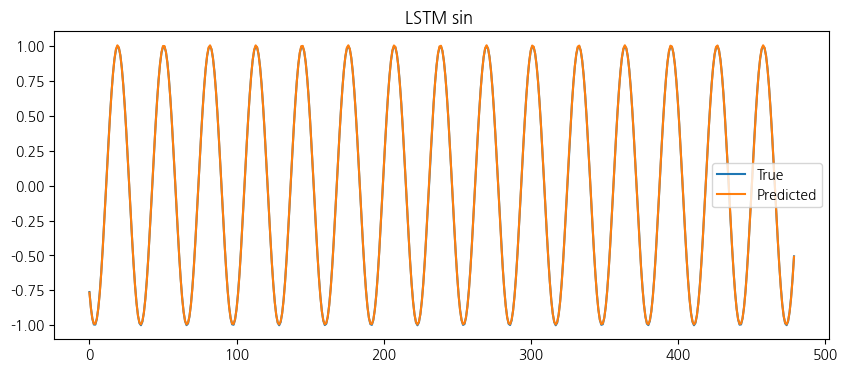

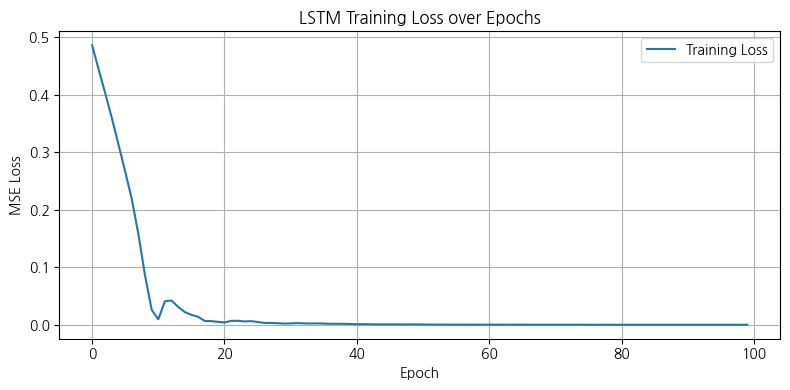

In [28]:
# 예측 시각화
model.eval()
with torch.no_grad():
    pred = model(X).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(Y.squeeze().numpy(), label="True")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("LSTM sin ")
plt.show()


# 손실 그래프 시각화
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


아래 코드는 코드는 새로운 학습을 수행하는 것이 아니라,
이미 전체 구간(0~100)의 데이터를 사용해 학습된 LSTM 모델이
훈련에 사용된 구간(왼쪽, 파란색) 과
그 이후 이어지는 구간(오른쪽, 빨간색) 에서
어떻게 예측하는지를 시각적으로 비교하기 위한 코드입니다.

즉, 여기서의 “train”과 “test”는
모델 성능을 평가하기 위한 엄밀한 데이터 분할이 아니라,
시간 축 기준으로 앞부분과 뒷부분을 구분해 보여주는 시각적 구분선 역할을 합니다.

모델은 이미 전체 데이터(500개 점)로 학습되었기 때문에,
빨간색 구간(“test”)도 사실상 모델이 한 번 본 적 있는 데이터 구간입니다.
따라서 “테스트 평가”라기보다는,
LSTM이 학습한 sin 패턴을 얼마나 자연스럽게 이어서 예측할 수 있는지를 시각적으로 확인하는 과정이라고 보는 것이 더 정확합니다.

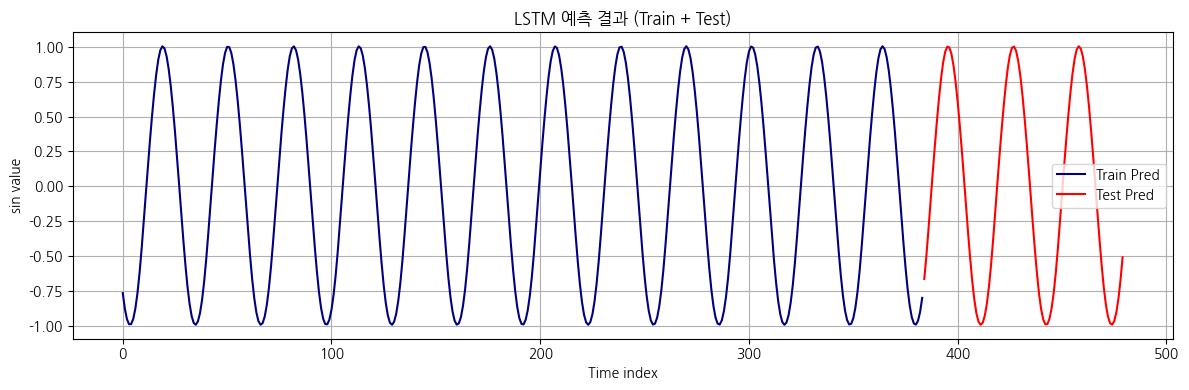

In [29]:
# 1. 훈련/테스트 분할 (batch 차원 기준)
train_ratio = 0.8
split_idx = int(X.shape[1] * train_ratio)

X_train = X[:, :split_idx, :].clone()   # shape: (20, 384, 1)
Y_train = Y[:split_idx].clone()         # shape: (384, 1)
X_test = X[:, split_idx:, :].clone()    # shape: (20, 96, 1)
Y_test = Y[split_idx:].clone()          # shape: (96, 1)

# 2. 예측 수행
model.eval()
with torch.no_grad():
    pred_train = model(X_train).squeeze().cpu().numpy()  # (384,)
    pred_test = model(X_test).squeeze().cpu().numpy()    # (96,)

# 3. 정답도 numpy로 변환
Y_train_np = Y_train.squeeze().cpu().numpy()
Y_test_np = Y_test.squeeze().cpu().numpy()

# 4. 예측 결과 시각화
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(Y_train_np)), pred_train, label="Train Pred", color="navy")
plt.plot(np.arange(len(Y_train_np), len(Y_train_np) + len(Y_test_np)), pred_test, label="Test Pred", color="red")
plt.title("LSTM 예측 결과 (Train + Test)")
plt.xlabel("Time index")
plt.ylabel("sin value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
import numpy as np
import plotly.graph_objects as go

# sin(x) 곡선 정의: 한 주기를 충분히 표현하기 위해 0 ~ 2π
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

# 시퀀스 분할 함수
def make_sequence(data, seq_len):
    x_seq, y_seq = [], []
    for i in range(len(data) - seq_len):
        x_seq.append(data[i:i+seq_len])
        y_seq.append(data[i+seq_len])
    return np.array(x_seq), np.array(y_seq)

# 시퀀스 길이를 길게 설정 (거의 한 주기를 담도록)
seq_len = 60
batch_size = 5
X, _ = make_sequence(y, seq_len)
X = X[:batch_size]  # 앞쪽 배치 일부 선택
X = X[..., np.newaxis]             # shape: (batch, seq_len, 1)
X = np.transpose(X, (1, 0, 2))     # shape: (seq_len, batch, 1)

# Plotly 3D 시각화
fig = go.Figure()

for b in range(batch_size):
    z_vals = X[:, b, 0]                # sin 값
    x_vals = np.full(seq_len, b)      # 배치 인덱스
    y_vals = np.arange(seq_len)       # 시간 순서

    fig.add_trace(go.Scatter3d(
        x=x_vals,
        y=y_vals,
        z=z_vals,
        mode='lines+markers',
        marker=dict(size=3),
        line=dict(width=4),
        name=f'Seq {b}'
    ))

fig.update_layout(
    title='LSTM 입력 시퀀스 (길게 늘려 sin 주기 전체 표현)',
    scene=dict(
        xaxis_title='Batch index',
        yaxis_title='Time step',
        zaxis_title='sin value',
        zaxis=dict(range=[-1.2, 1.2])
    ),
    width=900,
    height=600
)

fig.show()
